In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)
np.random.seed(0)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_subset_indices = []
for i in range(10):
    class_indices = np.where(train_dataset.targets == i)[0]
    np.random.shuffle(class_indices)
    train_subset_indices.extend(class_indices[:1000])
train_subset = torch.utils.data.Subset(train_dataset, train_subset_indices)

100%|██████████| 9912422/9912422 [00:00<00:00, 85458810.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19544319.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21932651.48it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 18604032.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class ShallowClassifier(nn.Module):
    def __init__(self, k, p):
        super(ShallowClassifier, self).__init__()
        self.fc1 = nn.Linear(784, k)
        self.dropout = nn.Dropout(p)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(k, 10)
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x #self.softmax(x)

In [4]:
def train(model, optimizer, criterion, train_loader, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = 100.0 * correct / total
    return epoch_loss, epoch_accuracy

In [5]:
def test(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_accuracy = 100.0 * correct / total
    return epoch_accuracy

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
K = [1, 5, 10, 20, 40]
P = [1.0, 0.5, 0.1]

##2.1 Fix p = 1.0 which is the case of “no dropout regularization”. 
##Plot the test and training accuracy as a function of k. 
###Q1: As k increases, does the performance improve? 
###Ans: Yes, as k increases, the training and test accuracies also increases.
###Q2: At what k, training accuracy becomes 100%?
###Ans: At k=40, the training accuracy becomes almost 100%.

In [7]:
test_accuracy = []
train_accuracy = []
train_loss=[]
pi=1.0   
for k in K:
    model = ShallowClassifier(k,1.0-pi).to(device)
    optimizer = optim.Adam(model.parameters())#,lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    for epoch in range(80):
        train_loss_epoch, train_acc_epoch = train(model, optimizer, criterion, train_loader, device)
    
    test_acc = test(model, criterion, test_loader, device)
    
    train_accuracy.append(train_acc_epoch)
    test_accuracy.append(test_acc)
    train_loss.append(train_loss_epoch)

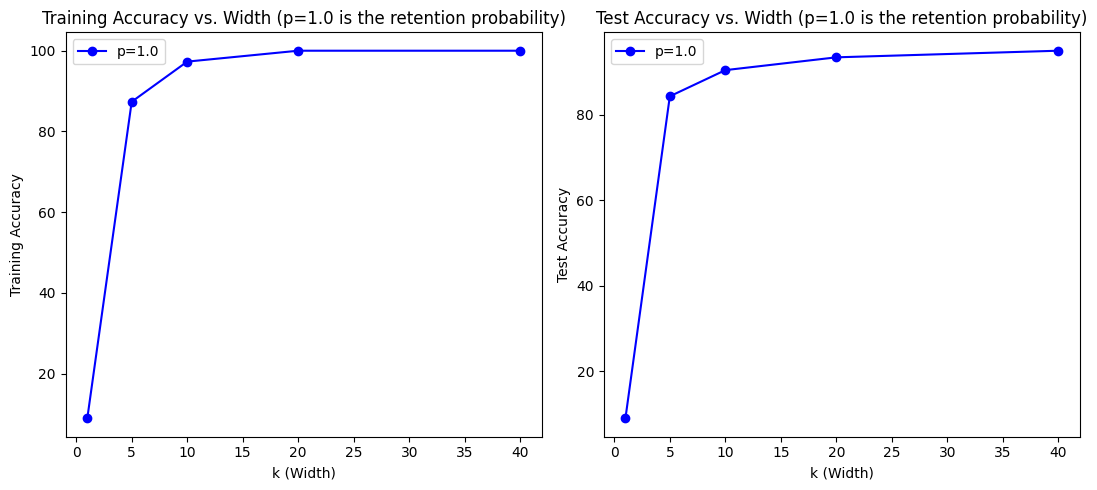

In [8]:
plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.plot(K, train_accuracy, 'bo-', label='p=1.0')
plt.xlabel('k (Width)')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Width (p=1.0 is the retention probability)')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(K, test_accuracy, 'bo-', label='p=1.0')
plt.xlabel('k (Width)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Width (p=1.0 is the retention probability)')
plt.legend()
plt.tight_layout()
plt.show()

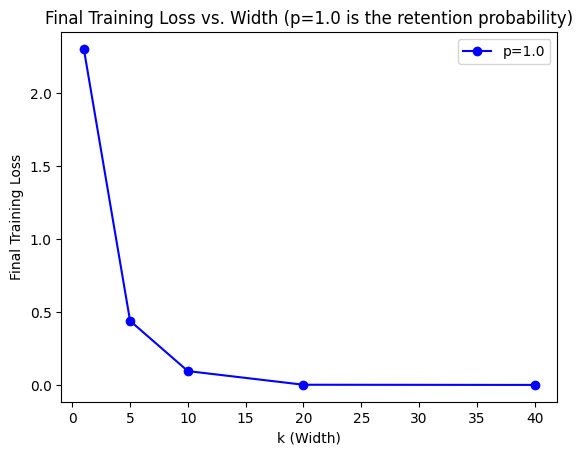

In [9]:
plt.plot(K, train_loss, 'bo-', label='p=1.0')
plt.xlabel('k (Width)')
plt.ylabel('Final Training Loss')
plt.title('Final Training Loss vs. Width (p=1.0 is the retention probability)')
plt.legend()
plt.show()

##2.2 Plot the training accuracy as a function of k and for different p ∈ P on the same plot. 
###Q1: What is the role of p on training accuracy?
###Ans: A lower value of p decreases the training accuracy due to higher drop out.
###Q2 When p is smaller, is it easier to optimize or more difficult? For each choice of p, determine at what choice of k, training accuracy becomes 100%.
###Ans: When p is smaller, it is harder to optimise. For all p, a higher k gives better training accuracy with k=40 giving the highest accuracy for all p. For k=40 and p=1.0, the training accuracy is almost 100%, for k=40 and p=0.5, the training accuracy is almost 90% but for k=40 and p=0.1, the accuracy is 40%.

In [10]:
train_losses = []
train_accuracies = []
test_accuracies = []

for p in P:
    test_accuracy = []
    train_accuracy = []
    train_loss = []
    
    for k in K:
        model = ShallowClassifier(k,1.0-p).to(device)
        optimizer = optim.Adam(model.parameters())#, lr=0.001)
        criterion = nn.CrossEntropyLoss()
        
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        for epoch in range(80):
            train_loss_epoch, train_acc_epoch = train(model, optimizer, criterion, train_loader, device)
        
        test_acc = test(model, criterion, test_loader, device)
        
        train_loss.append(train_loss_epoch)
        train_accuracy.append(train_acc_epoch)
        test_accuracy.append(test_acc)
        
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

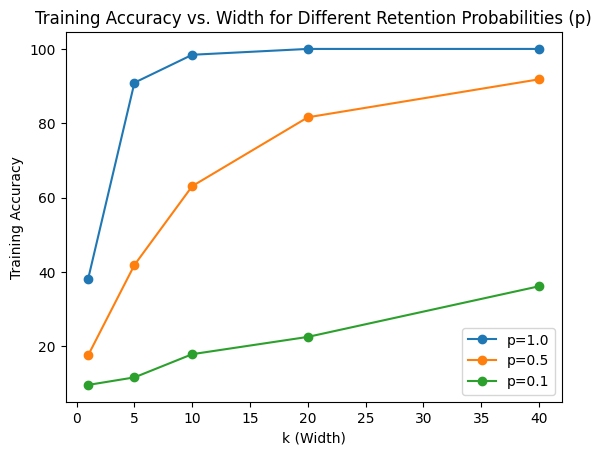

In [11]:
for i, p in enumerate(P):
    plt.plot(K, train_accuracies[i], 'o-', label=f'p={p}')
plt.xlabel('k (Width)')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Width for Different Retention Probabilities (p)')
plt.legend()
plt.show()

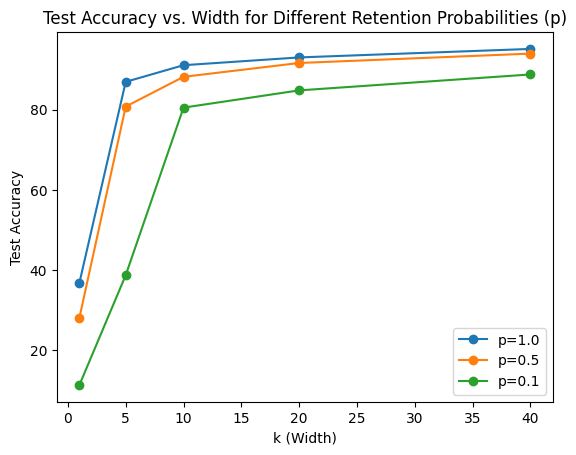

In [12]:
for i, p in enumerate(P):
    plt.plot(K, test_accuracies[i], 'o-', label=f'p={p}')
plt.xlabel('k (Width)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Width for Different Retention Probabilities (p)')
plt.legend()
plt.show()

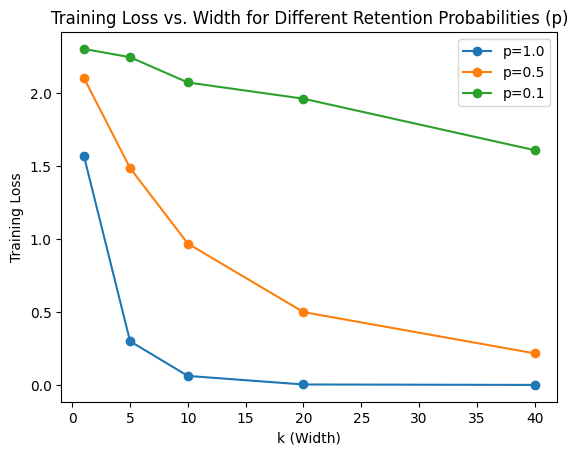

In [13]:
for i, p in enumerate(P):
    plt.plot(K, train_losses[i], 'o-', label=f'p={p}')
plt.xlabel('k (Width)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Width for Different Retention Probabilities (p)')
plt.legend()
plt.show()


In [14]:
def add_noise(dataset):
    total_samples = len(dataset)
    noisy_samples = int(0.4 * total_samples)

    selected_idx = np.random.choice(total_samples, noisy_samples, replace=False)
    
    for id in selected_idx:
        new_label=torch.randint(0, 10, size=(1,)).item()
        while(new_label==dataset.targets[id]):
          new_label=torch.randint(0, 10, size=(1,)).item()
        dataset.targets[id] = new_label

In [15]:
torch.manual_seed(42)
np.random.seed(42)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
add_noise(train_dataset)
train_subset_indices = []
for i in range(10):
    class_indices = np.where(train_dataset.targets == i)[0]
    np.random.shuffle(class_indices)
    train_subset_indices.extend(class_indices[:1000])
train_subset = torch.utils.data.Subset(train_dataset, train_subset_indices)

In [16]:
train_losses = []
train_accuracies = []
test_accuracies = []

for p in P:
    test_accuracy = []
    train_accuracy = []
    train_loss = []
    
    for k in K:
        model = ShallowClassifier(k,1.0-p).to(device)
        optimizer = optim.Adam(model.parameters())#, lr=0.001)
        criterion = nn.CrossEntropyLoss()
        
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
        
        for epoch in range(80):
            train_loss_epoch, train_acc_epoch = train(model, optimizer, criterion, train_loader, device)
        
        test_acc = test(model, criterion, test_loader, device)
        
        train_loss.append(train_loss_epoch)
        train_accuracy.append(train_acc_epoch)
        test_accuracy.append(test_acc)
        
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)


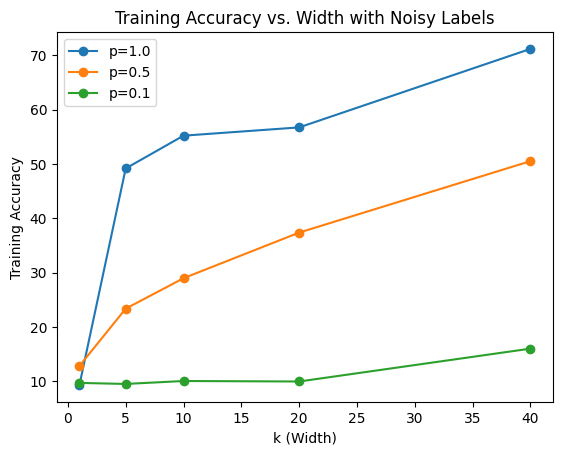

In [17]:
for i, p in enumerate(P):
    plt.plot(K, train_accuracies[i], 'o-', label=f'p={p}')
plt.xlabel('k (Width)')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs. Width with Noisy Labels')
plt.legend()
plt.show()

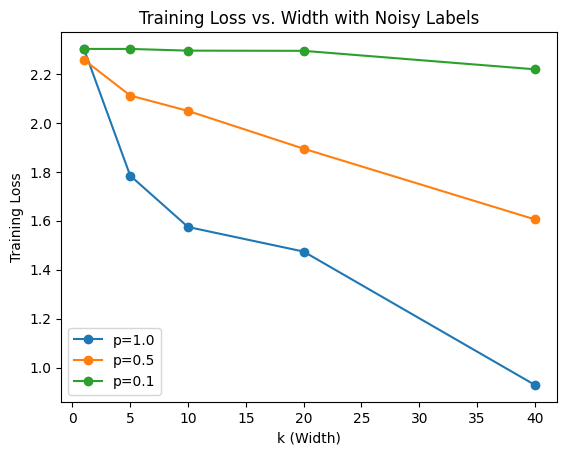

In [18]:
for i, p in enumerate(P):
    plt.plot(K, train_losses[i], 'o-', label=f'p={p}')
plt.xlabel('k (Width)')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Width with Noisy Labels')
plt.legend()
plt.show()

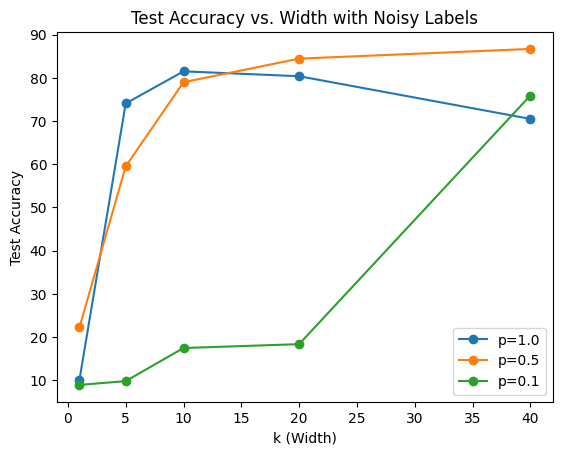

In [19]:
for i, p in enumerate(P):
    plt.plot(K, test_accuracies[i], 'o-', label=f'p={p}')
plt.xlabel('k (Width)')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs. Width with Noisy Labels')
plt.legend()
plt.show()